In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Load the dataset
data = pd.read_csv("/content/AirPassengers.csv")
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
passengers = data['#Passengers'].values.astype('float32')
data

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


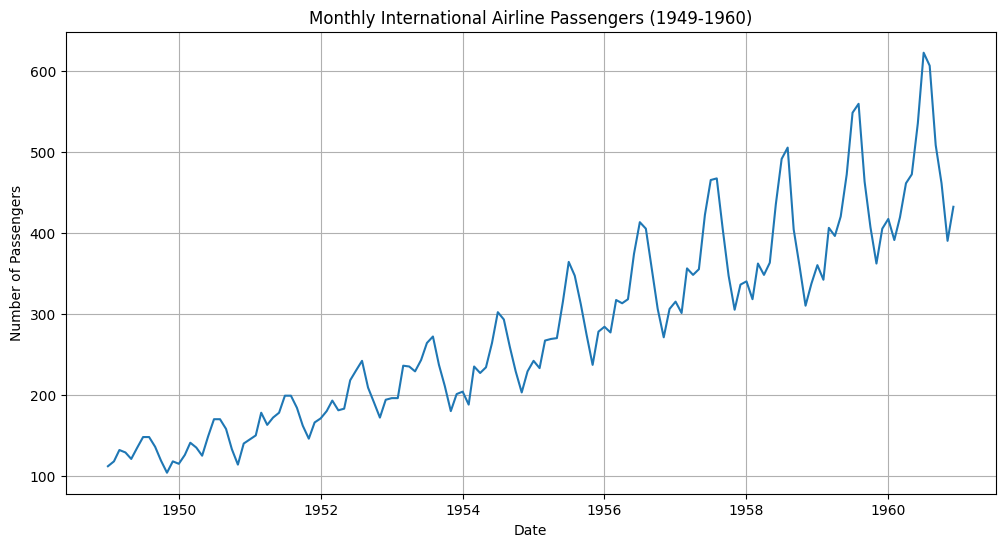

In [4]:
# Plot the original data
plt.figure(figsize=(12, 6))
plt.plot(data.index, passengers)
plt.title('Monthly International Airline Passengers (1949-1960)')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.grid(True)
plt.show()

In [6]:
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
passengers_scaled = scaler.fit_transform(passengers.reshape(-1, 1))
train_size = int(len(passengers_scaled) * 0.67)
test_size = len(passengers_scaled) - train_size
train, test = passengers_scaled[0:train_size,:], passengers_scaled[train_size:len(passengers_scaled),:]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
92/92 - 5s - 49ms/step - loss: 0.0167 - val_loss: 0.0316
Epoch 2/100
92/92 - 1s - 8ms/step - loss: 0.0063 - val_loss: 0.0298
Epoch 3/100
92/92 - 1s - 6ms/step - loss: 0.0063 - val_loss: 0.0285
Epoch 4/100
92/92 - 0s - 5ms/step - loss: 0.0064 - val_loss: 0.0459
Epoch 5/100
92/92 - 0s - 5ms/step - loss: 0.0059 - val_loss: 0.0233
Epoch 6/100
92/92 - 0s - 5ms/step - loss: 0.0050 - val_loss: 0.0272
Epoch 7/100
92/92 - 0s - 5ms/step - loss: 0.0049 - val_loss: 0.0224
Epoch 8/100
92/92 - 1s - 5ms/step - loss: 0.0049 - val_loss: 0.0283
Epoch 9/100
92/92 - 1s - 6ms/step - loss: 0.0045 - val_loss: 0.0312
Epoch 10/100
92/92 - 0s - 5ms/step - loss: 0.0049 - val_loss: 0.0240
Epoch 11/100
92/92 - 1s - 7ms/step - loss: 0.0046 - val_loss: 0.0207
Epoch 12/100
92/92 - 1s - 7ms/step - loss: 0.0049 - val_loss: 0.0210
Epoch 13/100
92/92 - 0s - 5ms/step - loss: 0.0043 - val_loss: 0.0378
Epoch 14/100
92/92 - 0s - 5ms/step - loss: 0.0039 - val_loss: 0.0200
Epoch 15/100
92/92 - 0s - 5ms/step - loss:

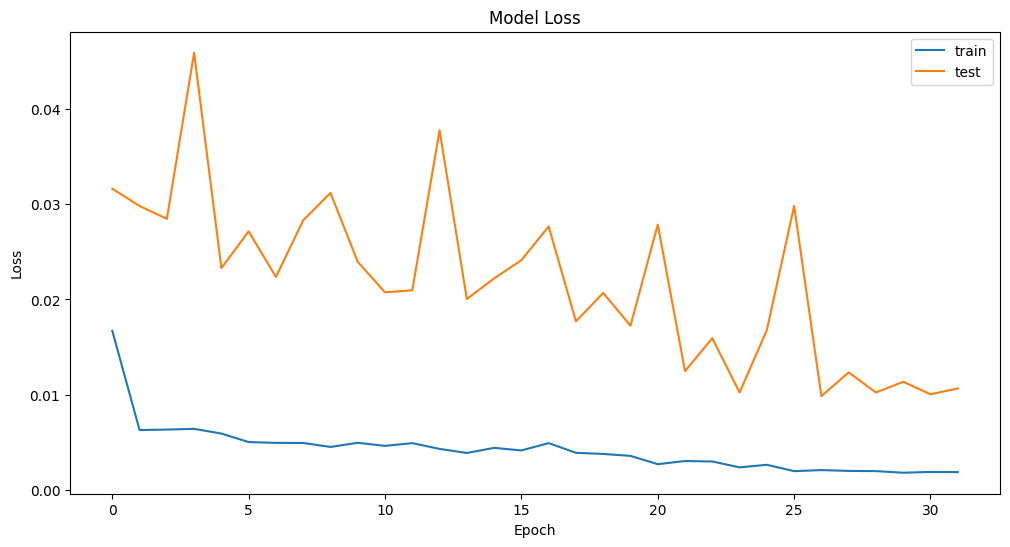

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Train Score: 21.41 RMSE
Test Score: 51.40 RMSE


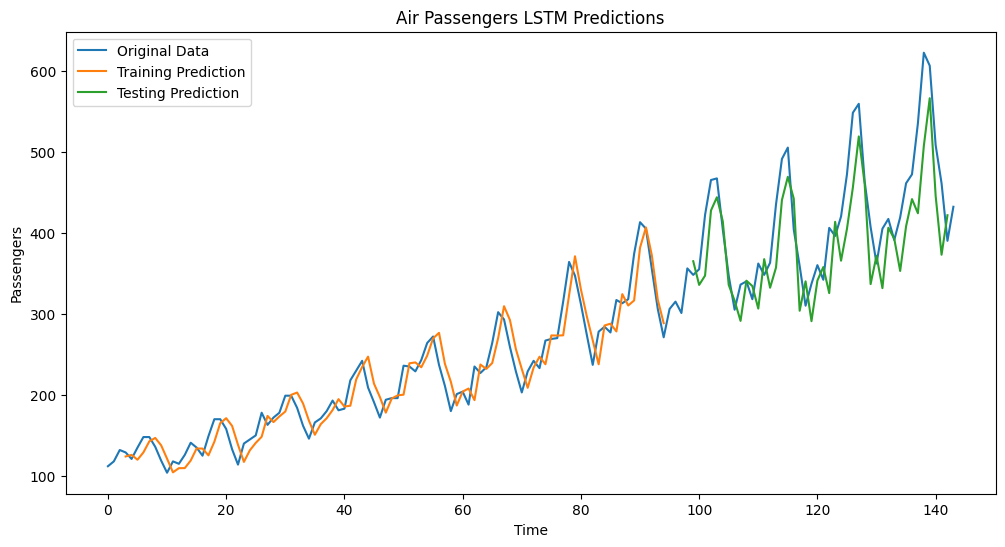

In [8]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Reshape into X=t and Y=t+1
look_back = 3
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=1,
    verbose=2,
    callbacks=[early_stop]
)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions back to original scale
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Calculate root mean squared error
train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
print(f'Train Score: {train_score:.2f} RMSE')
test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print(f'Test Score: {test_score:.2f} RMSE')

# Shift train predictions for plotting
train_predict_plot = np.empty_like(passengers_scaled)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict)+look_back, :] = train_predict

# Shift test predictions for plotting
test_predict_plot = np.empty_like(passengers_scaled)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(look_back*2)+1:len(passengers_scaled)-1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(passengers_scaled), label='Original Data')
plt.plot(train_predict_plot, label='Training Prediction')
plt.plot(test_predict_plot, label='Testing Prediction')
plt.title('Air Passengers LSTM Predictions')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend()
plt.show()